# Processing Yelp Data for Machine Learning Classification

Separate Notebook has been created due to large size of data files - too large to deal with directly in pandas, will have to preprocess as follows:

1. iterate through json files for business and review data
2. utilize sqlite3 to select relevant data, save to a new file
3. process new dataframe through separate Notebook

In [4]:
#!pip install ijson

In [2]:
import pandas as pd
import json
import sqlite3
import seaborn as sns
from collections import Counter

In [3]:
# Open the JSON file in read mode
cities = []
with open('data/yelp_academic_dataset_business.json', 'r', encoding='utf-8') as file:
    # Initialize the JSON parser
    parser = json.JSONDecoder()

    # Read the file line by line
    for line in file:
        # Parse the JSON data from the current line
        parsed_data, idx = parser.raw_decode(line)

        # Process the parsed data
        # Example: Print the city from each JSON object
        if 'city' in parsed_data:
            cities.append(parsed_data['city'])
cities[:10]

['Santa Barbara',
 'Affton',
 'Tucson',
 'Philadelphia',
 'Green Lane',
 'Ashland City',
 'Brentwood',
 'St. Petersburg',
 'Affton',
 'Nashville']

In [4]:
# Open the JSON file in read mode, create keyword variable for incremental features:
keyword = 'is_open'
keyword_list = []
with open('data/yelp_academic_dataset_business.json', 'r', encoding='utf-8') as file:
    # Initialize the JSON parser
    parser = json.JSONDecoder()
    for line in file:
        parsed_data, idx = parser.raw_decode(line)
        if keyword in parsed_data:
            keyword_list.append(parsed_data[keyword])
            
keyword_list[:10]

[0, 1, 0, 1, 1, 1, 1, 1, 0, 1]

In [5]:
len(keyword_list)

150346

In [7]:
keyword = 'stars'
keyword_list = []
with open('data/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as file:
    parser = json.JSONDecoder()
    for line in file:
        parsed_data, idx = parser.raw_decode(line)
        if keyword in parsed_data:
            keyword_list.append(parsed_data[keyword])
            
keyword_list[:10]

[3.0, 5.0, 3.0, 5.0, 4.0, 1.0, 5.0, 5.0, 3.0, 3.0]

In [15]:
len(keyword_list)

6990280

In [6]:
element_counts = Counter(keyword_list)
# Create a dictionary where keys are unique values and values are their counts
unique_values_count_dict = {key: value for key, value in element_counts.items()}
print(unique_values_count_dict)

{0: 30648, 1: 119698}


# Creating a Dataframe for desired data

In [3]:
# Create an SQLite connection and cursor
conn = sqlite3.connect('yelp_data.db')
cursor = conn.cursor()

# Create tables for 'review' and 'business' data
cursor.execute('''
    CREATE TABLE IF NOT EXISTS review (
        review_id TEXT PRIMARY KEY,
        text TEXT,
        business_id TEXT,
        stars FLOAT
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS business (
        business_id TEXT PRIMARY KEY,
        is_open INTEGER,
        review_count INTEGER,
        stars FLOAT
    )
''')

# Open and parse the review JSON file
with open('yelp_data/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as review_file:
    for line in review_file:
        review_data = json.loads(line)
        cursor.execute('''
            INSERT INTO review (review_id, text, business_id, stars)
            VALUES (?, ?, ?, ?)
        ''', (review_data['review_id'], review_data['text'], review_data['business_id'], review_data['stars']))

# Open and parse the business JSON file
with open('yelp_data/yelp_academic_dataset_business.json', 'r', encoding='utf-8') as business_file:
    for line in business_file:
        business_data = json.loads(line)
        cursor.execute('''
            INSERT INTO business (business_id, is_open, review_count, stars)
            VALUES (?, ?, ?, ?)
        ''', (business_data['business_id'], business_data['is_open'], business_data['review_count'], business_data['stars']))

# Commit changes and close the connection
conn.commit()
conn.close()


In [10]:
# Reconnect to the SQLite database
conn = sqlite3.connect('yelp_data.db')

# Query data from the database and join 'review' and 'business' tables
query = '''
    SELECT r.text, r.stars, b.stars, b.review_count, b.is_open
    FROM review r
    INNER JOIN business b ON r.business_id = b.business_id
'''

# Execute the query and create a Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Print the resulting DataFrame
print(df.head())


                                                text  stars  stars  \
0  If you decide to eat here, just be aware it is...    3.0    3.0   
1  I've taken a lot of spin classes over the year...    5.0    5.0   
2  Family diner. Had the buffet. Eclectic assortm...    3.0    3.5   
3  Wow!  Yummy, different,  delicious.   Our favo...    5.0    4.0   
4  Cute interior and owner (?) gave us tour of up...    4.0    4.0   

   review_count  is_open  
0           169        1  
1           144        0  
2            47        1  
3           181        1  
4            32        0  


In [11]:
df.shape

(6990280, 5)

Text(0, 0.5, 'Count')

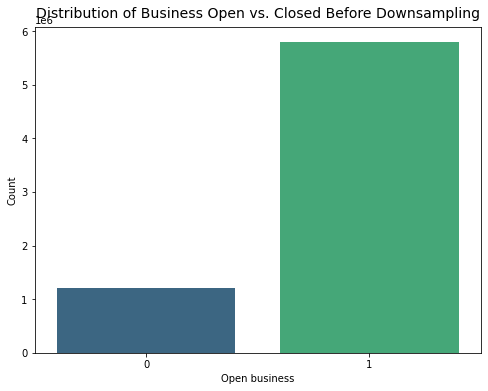

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.barplot(x=df['is_open'].value_counts().index, y=df['is_open'].value_counts().values, palette="viridis")
plt.title('Distribution of Business Open vs. Closed Before Downsampling', fontdict={'fontsize': 14, 'verticalalignment': 'bottom'})
plt.xlabel('Open business')
plt.ylabel('Count')

In [20]:
column_names = ['text', 'review_rating', 'business_rating_avg', 'review_count', 'is_open']
df.columns = column_names
df.head()

,text,review_rating,business_rating_avg,review_count,is_open
0,"If you decide to eat here, just be aware it is...",3.0,3.0,169,1
1,I've taken a lot of spin classes over the year...,5.0,5.0,144,0
2,Family diner. Had the buffet. Eclectic assortm...,3.0,3.5,47,1
3,"Wow! Yummy, different, delicious. Our favo...",5.0,4.0,181,1
4,Cute interior and owner (?) gave us tour of up...,4.0,4.0,32,0


In [21]:
df['is_open'].value_counts()

1    5791234
0    1199046
Name: is_open, dtype: int64

In [22]:
#downsample majority class to balance the dataset
df_minority = df[df['is_open'] == 0]
df_majority = df[df['is_open'] == 1]

downsampled_majority_df  = df_majority.sample(len(df_minority), random_state = 53)
df_balanced = pd.concat([downsampled_majority_df, df_minority], axis=0)
df_balanced['is_open'].value_counts()

1    1199046
0    1199046
Name: is_open, dtype: int64

Text(0, 0.5, 'Count')

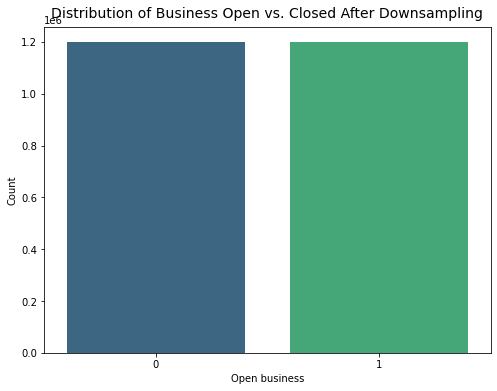

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.barplot(x=df_balanced['is_open'].value_counts().index, y=df_balanced['is_open'].value_counts().values, palette="viridis")
plt.title('Distribution of Business Open vs. Closed After Downsampling', fontdict={'fontsize': 14, 'verticalalignment': 'bottom'})
plt.xlabel('Open business')
plt.ylabel('Count')

In [15]:
df_balanced['is_open'].value_counts()

1    1199046
0    1199046
Name: is_open, dtype: int64

In [10]:
#save this dataframe for Machine Learning Classification Notebook
df_balanced.to_csv('test_yelp.csv', index=False)

## Incremental Data Exploration to determine other features for classification models

In [3]:
# Open the JSON file in read mode
keyword = 'text'
keyword_list = []
with open('data/yelp_academic_dataset_tip.json', 'r', encoding='utf-8') as tip_file:
    # Initialize the JSON parser
    parser = json.JSONDecoder()

    # Read the file line by line
    for line in tip_file:
        # Parse the JSON data from the current line
        parsed_data, idx = parser.raw_decode(line)

        # Process the parsed data
        # Example: Print the city from each JSON object
        if keyword in parsed_data:
            keyword_list.append(parsed_data[keyword])
len(keyword_list)

908915

In [4]:
keyword_list[:10]

['Avengers time with the ladies.',
 'They have lots of good deserts and tasty cuban sandwiches',
 "It's open even when you think it isn't",
 'Very decent fried chicken',
 'Appetizers.. platter special for lunch',
 'Chili Cup + Single Cheeseburger with onion, pickle, and relish + Vanilla Coca-Cola...so far.',
 "Saturday, Dec 7th 2013, ride Patco's Silver Sleigh w/ Santa & his elves on a decorated train into Center City. Trains leave from Lindenwold at 10am, 11:15am, & 12:30pm, and make all stops. Great for kids!",
 'This is probably the best place in the cool Springs area to watch a game and eat',
 'Tacos',
 'Starbucks substitute in boring downtown Tampa. Ugh. Never again!']